In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Original

In [2]:
def score_sequence(mol):
    """Return (penalized_score, raw_survivors_in_region)."""
    
    n_x, n_y, n_z, is_lost = mol[:, 0], mol[:, 1], mol[:, 2], mol[:, 5]
    mask = (is_lost == 0) & (n_x < 2) & (n_y < 2) & (n_z < 140)
    raw = int(cp.count_nonzero(mask).get())
    return raw

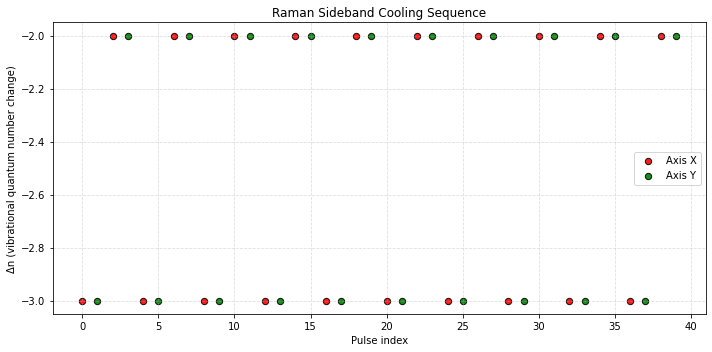

In [3]:
original_gpu = cr.get_original_sequences_gpu()  # list/tuple of cp.ndarray blocks

# Repeat each block along the first axis, then concatenate in order
blocks = [
    cp.tile(original_gpu[0], (10, 1)),  # repeat 10 times
]

seq_gpu = cp.concatenate(blocks, axis=0)
cr.visualize_sequence(seq_gpu)

In [5]:
np.save("XY_original.npy", cp.asarray(seq_gpu))

Raman pulses: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


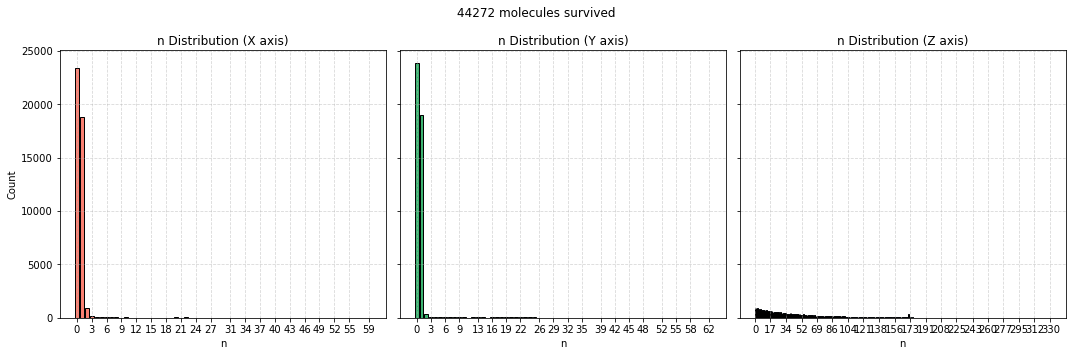

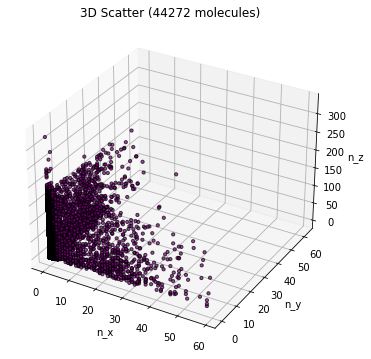

survival_rate_mean 0.88544
mot_mean [ 0.87545175  0.87382544 49.49582129]
mot_sem [0.00047551 0.00046521 0.00676013]


In [4]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(50_000, temp)
cr.raman_cool_with_pumping(mol_0, seq_gpu, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [5]:
score_sequence(mol_0)

39217

#### Optimized

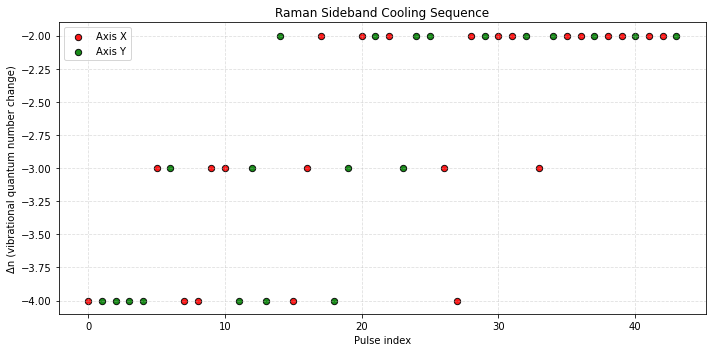

In [9]:
seq_op = cp.array(np.load("ga_runs/XY_20251027_170359/final_top5/top1_sequence.npy"))
cr.visualize_sequence(seq_op)

Raman pulses: 100%|██████████| 44/44 [00:26<00:00,  1.64it/s]


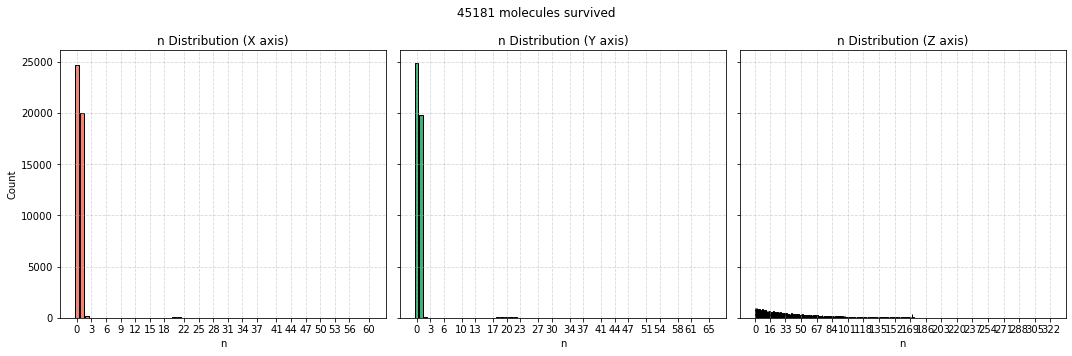

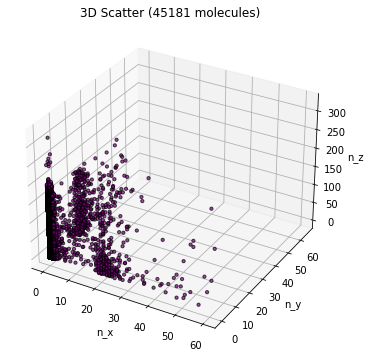

survival_rate_mean 0.90362
mot_mean [ 0.6190434   0.65153494 47.79719351]
mot_sem [0.0003096  0.000346   0.00647078]


In [10]:
temp = [25e-6, 25e-6, 25e-6]
mol_1 = cr.build_thermal_molecules_gpu(50_000, temp)
cr.raman_cool_with_pumping(mol_1, seq_op, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_1, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_1)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [13]:
score_sequence(mol_1) - 50*seq_op.shape[0]

40064

In [12]:
best_history = np.load("ga_runs/XY_20251027_170359/history_best.npy")
print(best_history)

[37478. 37741. 37741. 37774. 37962. 38064. 38195. 38404. 38592. 38913.
 38913. 38843. 39106. 39106. 39133. 39190. 39155. 39327. 39535. 39535.
 39500. 39535. 39537. 39683. 39764. 39769. 39780. 39887. 40008. 39958.
 40014. 39947. 39968. 40121. 40005. 40163. 40152. 40180. 40135. 40288.]


In [14]:
cr.save_molecules(mol_1, "mol_post_XY.npy")

[✓] Molecules saved to: C:\Users\LyuQi\Documents\optimize_sequence\XY\mol_post_XY.npy  (shape=(50000, 6))
